In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision.transforms import ToPILImage

In [42]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte imágenes a tensores de PyTorch
    transforms.Normalize((0.5,), (0.5,))  # Normaliza entre -1 y 1
])

train_dataset = datasets.MNIST(
    root='./data',        # Carpeta donde se descargará
    train=True,           # Datos de entrenamiento
    transform=transform,  # Transformaciones definidas antes
    download=True         # Descarga si no está presente
)

test_dataset = datasets.MNIST(
    root='./data',        # Carpeta donde se descargará
    train=False,          # Datos de prueba
    transform=transform,  # Transformaciones definidas antes
    download=True         # Descarga si no está presente
)

subset_size = 1000
rest_size = len(train_dataset) - subset_size
train_dataset, rest = random_split(train_dataset, [subset_size, rest_size])

In [43]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [44]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,dataset,transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self,index):
        img0, label0 = random.choice(self.dataset)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1, label1 = random.choice(self.dataset)
                if label0 == label1:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1, label1 = random.choice(self.dataset)
                if label0 != label1:
                    break

        img0 = ToPILImage()(img0)
        img1 = ToPILImage()(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(label0 != label1)], dtype=np.float32))

    def __len__(self):
        return len(self.dataset)

In [45]:
siamese_dataset = SiameseNetworkDataset(dataset=train_dataset,transform=transform)

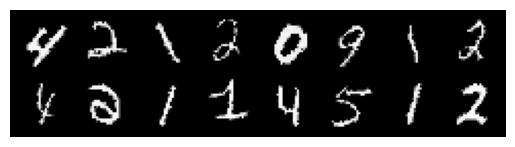

[0. 0. 0. 1. 1. 1. 0. 0.]


In [20]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same number, label is 0, same number in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [21]:
#create the Siamese Neural Network
class SiameseModel(nn.Module):
  def __init__(self, encoder):
    super(SiameseModel, self).__init__()
    encoder[0] = nn.Conv2d(1, 64, kernel_size=7,
                                   stride=2, padding=3, bias=False)
    self.encoder = encoder
    self.head = nn.Sequential(
          nn.Linear(512, 2)
      )

  def forward_once(self, x):
    # This function will be called for both images
    # Its output is used to determine the similiarity
    output = self.encoder(x)
    output = output.view(output.size()[0], -1)
    output = self.head(output)
    return output

  def forward(self, input1, input2):
      output1 = self.forward_once(input1)
      output2 = self.forward_once(input2)

      return output1, output2

In [22]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [23]:
resnet18 = torchvision.models.resnet18(pretrained=True)
backbone = nn.Sequential(*list(resnet18.children())[:-2])

In [24]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net = SiameseModel(encoder = backbone)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [13]:
print(len(train_dataset))

1000


Epoch number 0
 Current loss 1.4715280532836914

Epoch number 1
 Current loss 1.345125675201416

Epoch number 2
 Current loss 1.012288212776184

Epoch number 3
 Current loss 0.9467041492462158

Epoch number 4
 Current loss 0.7375367879867554

Epoch number 5
 Current loss 0.7843721508979797

Epoch number 6
 Current loss 0.4268454313278198

Epoch number 7
 Current loss 0.48194220662117004

Epoch number 8
 Current loss 0.44364985823631287

Epoch number 9
 Current loss 0.4849143922328949



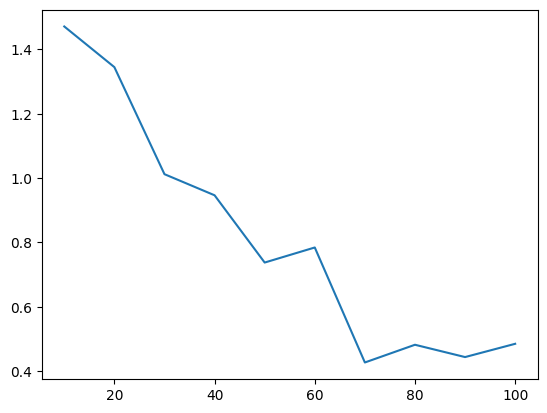

In [25]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(10):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader):

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 1000 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

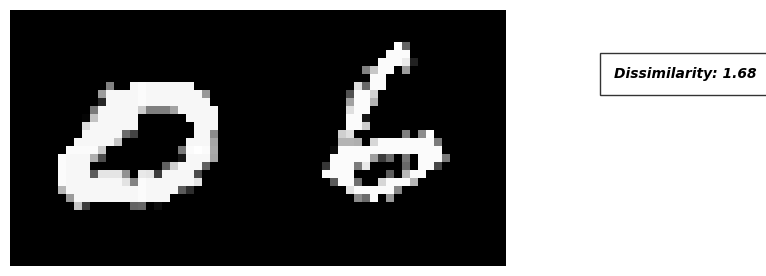

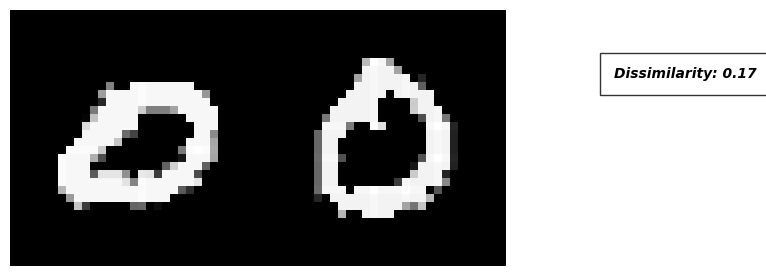

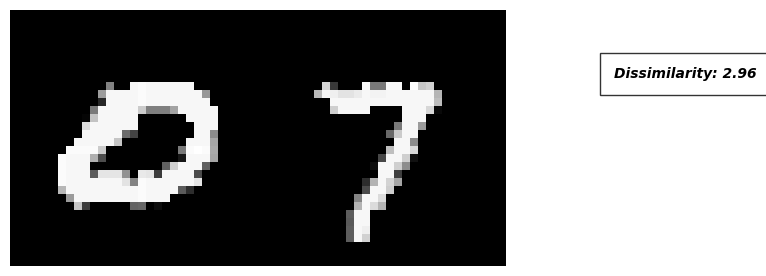

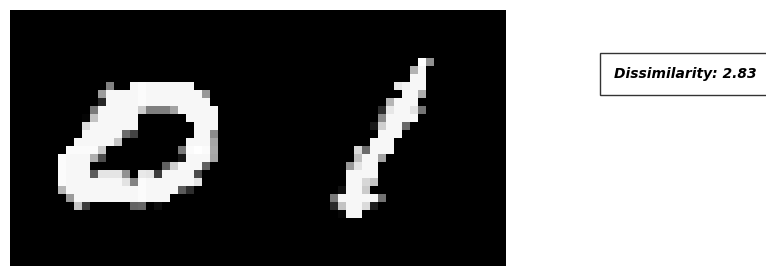

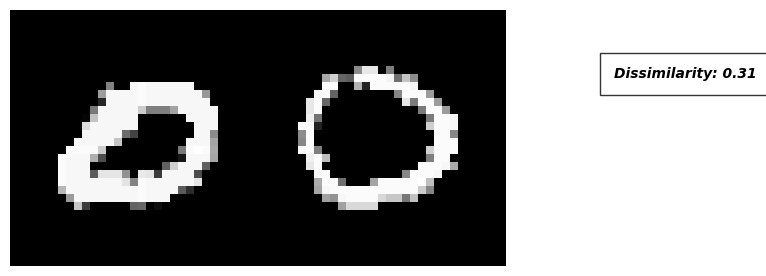

In [31]:
test = SiameseNetworkDataset(dataset=test_dataset,transform=transform)
test_dataloader = DataLoader(test, num_workers=2, batch_size=1, shuffle=True)

dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)
net.eval()

for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0, x1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

In [49]:
class SiameseNetworkDatasetTriplet(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):

        img1, label1 = random.choice(self.dataset)
        while True:
          #Look untill the same class image is found
          img2, label2 = random.choice(self.dataset)
          if label1 == label2:
              break
        while True:
          #Look untill the same class image is found
          img3, label3 = random.choice(self.dataset)
          if label1 != label3:
              break

        img1 = ToPILImage()(img1)
        img2 = ToPILImage()(img2)
        img3 = ToPILImage()(img3)
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3)

    def __len__(self):
        return len(self.dataset)

In [50]:
siamese_dataset2 = SiameseNetworkDatasetTriplet(dataset=train_dataset,transform=transform)

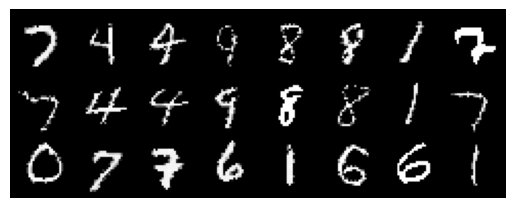

In [51]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset2,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)

imshow(torchvision.utils.make_grid(concatenated))

In [58]:
class SiameseModelTriplet(nn.Module):
  def __init__(self, encoder):
    super(SiameseModelTriplet, self).__init__()
    encoder[0] = nn.Conv2d(1, 64, kernel_size=7,
                                   stride=2, padding=3, bias=False)
    self.encoder = encoder
    self.head = nn.Sequential(
          nn.Linear(512, 2)
      )

  def forward_once(self, x):
    # This function will be called for all three images
    # Its output is used to determine the similiarity and disimilarity
    output = self.encoder(x)
    output = output.view(output.size()[0], -1)
    output = self.head(output)
    return output

  def forward(self, input1, input2, input3):
      output1 = self.forward_once(input1)
      output2 = self.forward_once(input2)
      output3 = self.forward_once(input3)

      return output1, output2, output3

In [59]:
# Define the Contrastive Loss Function
class TripletLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
      distance_positive = torch.pow(anchor - positive, 2)
      distance_negative = torch.pow(anchor - negative, 2)
      losses = F.relu(distance_positive - distance_negative + self.margin)
      return torch.mean(losses)

In [62]:
train_dataloader = DataLoader(siamese_dataset2,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net = SiameseModelTriplet(encoder = backbone)
criterion = TripletLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch number 0
 Current loss 1.9916263818740845

Epoch number 1
 Current loss 1.3834388256072998

Epoch number 2
 Current loss 1.1392695903778076

Epoch number 3
 Current loss 1.3446606397628784

Epoch number 4
 Current loss 1.3026052713394165

Epoch number 5
 Current loss 1.0526044368743896

Epoch number 6
 Current loss 0.6439626216888428

Epoch number 7
 Current loss 1.2871789932250977

Epoch number 8
 Current loss 0.764409601688385

Epoch number 9
 Current loss 0.801190972328186



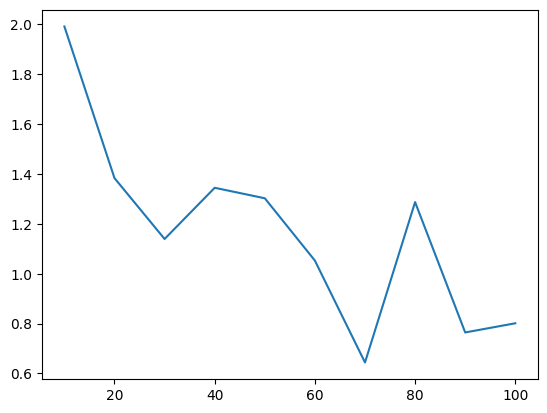

In [63]:
counter = []
triplet_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(10):

    # Iterate over batches
    for i, (img0, img1, img2) in enumerate(train_dataloader):

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2, output3 = net(img0, img1, img2)

        # Pass the outputs of the networks and label into the loss function
        triplet_loss = criterion(output1, output2, output3)

        # Calculate the backpropagation
        triplet_loss.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 1000 == 0 :
            print(f"Epoch number {epoch}\n Current loss {triplet_loss.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            triplet_history.append(triplet_loss.item())

show_plot(counter, triplet_history)

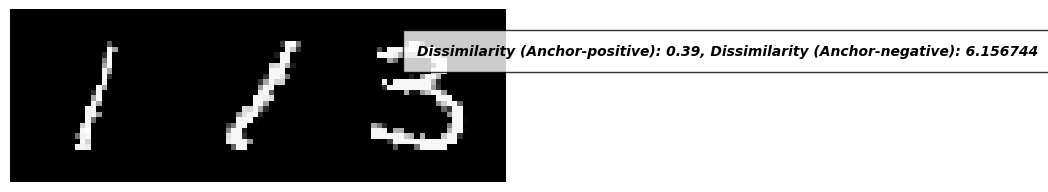

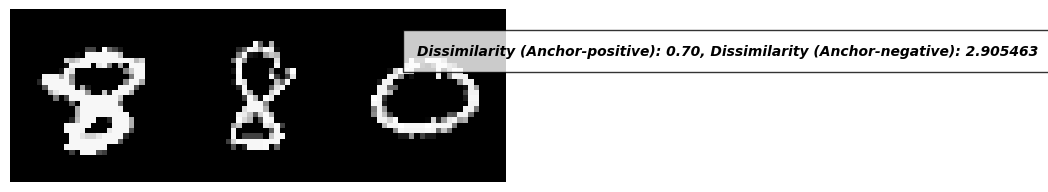

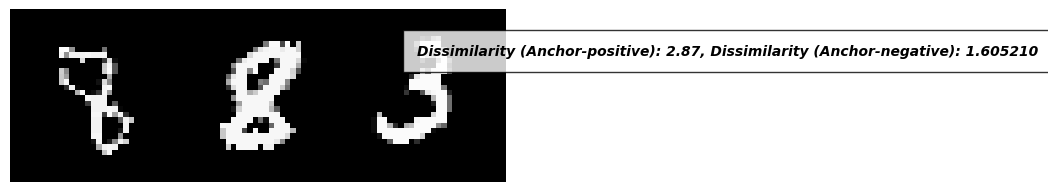

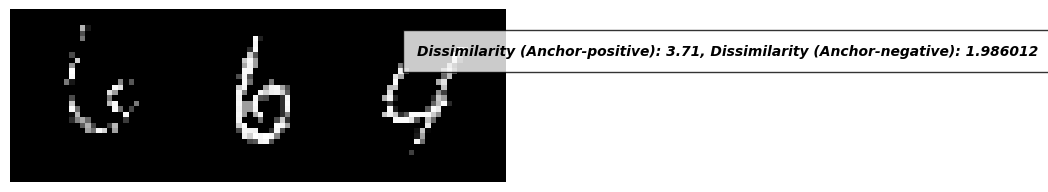

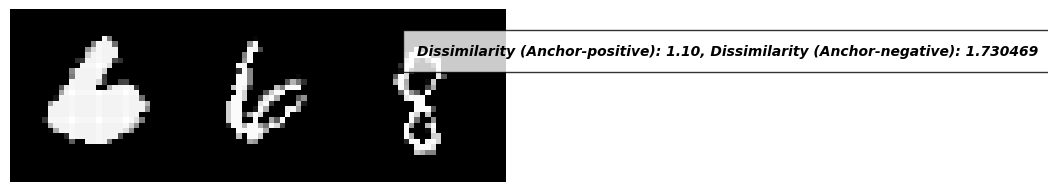

In [65]:
test = SiameseNetworkDatasetTriplet(dataset=test_dataset,transform=transform)
test_dataloader = DataLoader(test, num_workers=2, batch_size=1, shuffle=True)

dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)
net.eval()

for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    x0, x1, x2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1, x2))

    output1, output2, output3 = net(x0, x1, x2)
    euclidean_distance1 = F.pairwise_distance(output1, output2)
    euclidean_distance2 = F.pairwise_distance(output1, output3)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity (Anchor-positive): {euclidean_distance1.item():.2f}, Dissimilarity (Anchor-negative): {euclidean_distance2.item():-2f}')